## Assignment: Image recognition
- Alumno 1: Yeray Martínez Martínez
- Alumno 2: Juan Esteban Rincón Marín
- Alumno 3: Kevin Oscar Arce Vera

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

Lista de tareas para la entrega del 12 de octubre:

- [ ] EDA de los datos de rigor (desbalanceo, tipos, forma, normalizacion, etc, etc, etc)
- [ ] Data Augmentation para mejores datos y así a futuro está hecho
- [ ] La red Feedforward
- [ ] Análisis del entrenamiento y validación
- [ ] Mejoras(Ya lo vamos viendo)

# Ideas despues del seminario

1. Usar SGDR porque converge más rápido, y aquí se cobra por tiempo, no sé vosotros.
2. Lo de SB y LB está interesante, el pasar de batches pequeños a grandes ya sea con warm starting o dinamyc sampling
3. Pensar a ver si hacemos al revés el batch, el ruido al principio parece que ayuda, ya sea ocn el lr o el Batch size.
4. Aplicar SAM? ya pa tocar los huevos.
5. no sé, que alguien haga un dibujito o algo pa poner en la portada del report 

In [33]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [34]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [35]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [36]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./data/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [37]:
import json

# Load database
json_file = './data/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [38]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


Tomando como punto de partida este código que tan amablemente nuestro profesor nos ha dejado vemos a simple vista que el número de imágenes por clase no es del todo equitativa. Para medir el desbalanceo de las imágenes primero haremos uso de una métrica.

### Entropía de Clases
Esta es una métrica que nos permite medir cuan desbalanceado está todo el dataset y nos permitirá comparar el estado actual con el estado del dataset después de rebalancear las clases.

Este rango toma valores en el intervalo [0, log(k)] siendo k el número de clases, en este caso 13.
Cuanto mas bajo mas balanceado está el dataset, cuanto más cerca de log(13) más desbalanceado.
En caso de normalizar el valor el intervalo pasa a [0,1].

In [39]:
import math

total = sum(counts.values())  
entropy = -sum((i/total) * math.log(i/total) for i in counts.values())

print("Entropia de clases: ", entropy)
print("Valor normalizado: ", entropy/math.log(len(counts.keys())))

Entropia de clases:  2.3142789779240545
Valor normalizado:  0.9022708269821108


#### Observaciones

Observamos que si bien es verdad que el dataset no tiene las clases perfectamente balanceadas, nos da un valor de 0.90227, lo que nos indica que no hay una clase que domine por encima de las demás.

In [40]:
json_data["images"]["0"]

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'filename': 'xview_train/Building/0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'width': 224,
 'height': 224}

## Imágenes
Son archivos tiff que corresponden a una categoría de las 13.
Los labels estan en onehot.
La forma es de [224, 224, 3], lo que indica 3 canales de color e imágenes de 224x224.

Para el modelo se usan lo que se conoce como "generadores" que permiten cargar las imágenes en memoria en cada batch en lugar de tenerlo en un dataset ocupando memoria a lo tonto. Esto desgraciadamente choca con el data augmentation, pero yo dejo lo de normalizacion y ya me contais que os parece si lo dejamos así o probamos a hacerlo con data augmentation.

In [41]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [42]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                image = load_geoimage(filename).astype(np.float32)
                image = image/255 # minmax
                images.append(image)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [43]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [44]:
#esta mierda es pa sacar el maximo de los valores, se puede borrar en realidad
import numpy as np

def global_minmax(objs):
    gmin, gmax = float("inf"), float("-inf")
    for (filename, obj) in objs:
        img = load_geoimage(filename)   # (H, W, C)
        local_min = np.min(img)
        local_max = np.max(img)
        if local_min < gmin:
            gmin = local_min
        if local_max > gmax:
            gmax = local_max
    return gmin, gmax

# Uso
mn, mx = global_minmax(objs_train)
print("Mínimo global:", mn)
print("Máximo global:", mx)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import layers
import os, random, numpy as np, tensorflow as tf
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras import layers

class UniformNoiseClipped(layers.Layer):
    """
    Añade ruido uniforme ∈ [-width, +width] a las imágenes,
    garantizando salida en el rango [0, 1].
    """
    def __init__(self, width=0.02, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.width = width  # amplitud máxima del ruido
        self.seed = seed

    def call(self, x, training=None):
        if not training:
            return x
        # Genera ruido uniforme acotado
        noise = tf.random.uniform(tf.shape(x), -self.width, self.width, seed=self.seed, dtype=x.dtype)
        y = x + noise
        # Reencierra valores al rango [0,1]
        y = tf.clip_by_value(y, 0.0, 1.0)
        return tf.cast(y, tf.float32)

    def get_config(self):
        config = super().get_config()
        config.update({"width": self.width})
        return config


SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Parámetros (ajusta a tu gusto)
IMG = 224
P_FLIP = 0.5
ROT = 0.1                # ~±10 (fracción de vuelta; 0.1≈±36º). Para ±20º usa ~0.055.
ZOOM = (-0.2, 0.0)       # zoom in hasta 20% (no zoom out). Para in/out: (-0.2, 0.2).
BRIGHT = 0.2
CONTR = 0.2
GAUSS_STD = 2/255.

data_augmentation = keras.Sequential(
    [
        layers.Resizing(IMG, IMG),
        layers.RandomFlip(mode="horizontal", seed=SEED),
        layers.RandomRotation(ROT, fill_mode="reflect", interpolation="bilinear", seed=SEED+1),
        layers.RandomZoom(height_factor=ZOOM, width_factor=ZOOM, fill_mode="reflect", seed=SEED+2),
        layers.RandomBrightness(factor=BRIGHT, value_range=[0,1], seed=SEED+3),
        layers.RandomContrast(factor=CONTR, value_range=[0,1], seed=SEED+4),
        UniformNoise(width=0.07, seed=SEED+5)
    ],
    name="aug",
)

# Pruebas

[IN]  dtype: float32 min: 0.0 max: 1.0
[OUT] dtype: <dtype: 'float32'> min: 1.4901161193847656e-08 max: 0.9999995827674866


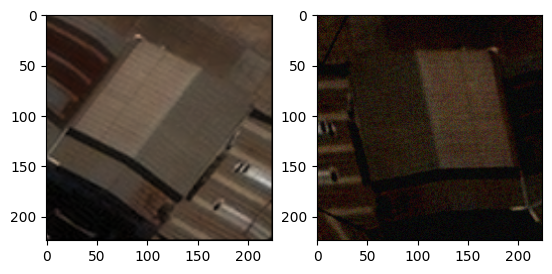

In [240]:
from matplotlib.pyplot import imshow

imgs_in, _ = next(train_generator)

print(
    "[IN]  dtype:", imgs_in.dtype,
    "min:", float(np.min(imgs_in)),
    "max:", float(np.max(imgs_in))
)

qwerty = data_augmentation(imgs_in, training=True)

print(
    "[OUT] dtype:", qwerty.dtype,
    "min:", float(tf.reduce_min(qwerty)),
    "max:", float(tf.reduce_max(qwerty))
)


plt.subplot(1, 2, 1)
imshow(imgs_in[0])

plt.subplot(1, 2, 2)
imshow(qwerty[0])
plt.show()


In [225]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [ ]:

# === DATASETS POR CLASE (balanceo al vuelo) ===
def make_ds(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)
    def _map(path, y):
        img = read_image(path)                 # 0..1, (H,W,C)
        if training:
            img = augment(img)                 # augment solo en train
        else:
            img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(y, tf.int32)
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    return ds